In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Download MNIST dataset
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [5]:
class_names = trainset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

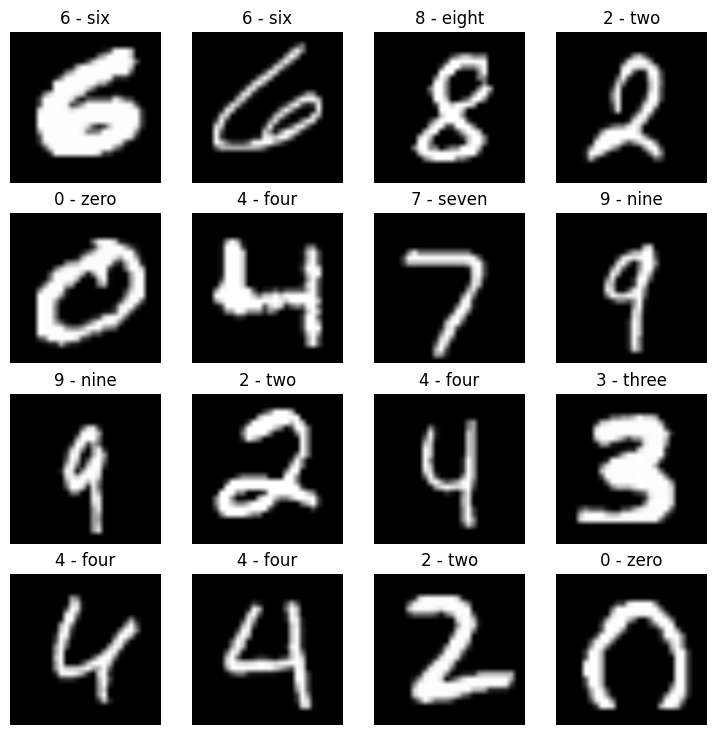

In [6]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [7]:
# Divide the dataset into training, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader = DataLoader(val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(testset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1500 batches of 32
Length of valid dataloader: 375 batches of 32
Length of test dataloader: 313 batches of 32


In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [20]:
# Training loop
def train_loop(model, num_epochs=10, loss_fn=nn.CrossEntropyLoss(), optimizer=None):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(num_epochs):
      # Training
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in train_dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_dataloader)
      train_accuracy = 100 * correct_train / total_train
      train_losses.append(train_loss)
      train_accs.append(train_accuracy)

      # Validation
      model.eval()
      running_loss = 0.0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
          for inputs, labels in valid_dataloader:
              inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
              outputs = model(inputs)
              loss = loss_fn(outputs, labels)
              running_loss += loss.item()

              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      val_loss = running_loss / len(valid_dataloader)
      val_accuracy = 100 * correct_val / total_val
      val_losses.append(val_loss)
      val_accs.append(val_accuracy)

      print(f"Epoch [{epoch + 1}/{num_epochs}] - "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

  return train_accs, train_losses, val_accs, val_losses


In [14]:
def plot_model(train_accs, val_accs, train_losses, val_losses):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_accs, label='Train')
  plt.plot(val_accs, label='Validation')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_losses, label='Train')
  plt.plot(val_losses, label='Validation')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

Adam optimizer


In [38]:
model = AlexNet(num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accs, train_losses, val_accs, val_losses = train_loop(model, 15, loss_fn, optimizer)

Epoch [1/15] - Train Loss: 0.3270, Train Accuracy: 89.59% - Validation Loss: 0.0979, Validation Accuracy: 97.30%
Epoch [2/15] - Train Loss: 0.1214, Train Accuracy: 96.65% - Validation Loss: 0.0792, Validation Accuracy: 97.65%
Epoch [3/15] - Train Loss: 0.1083, Train Accuracy: 96.97% - Validation Loss: 0.0449, Validation Accuracy: 98.65%
Epoch [4/15] - Train Loss: 0.0932, Train Accuracy: 97.53% - Validation Loss: 0.0522, Validation Accuracy: 98.62%
Epoch [5/15] - Train Loss: 0.0877, Train Accuracy: 97.55% - Validation Loss: 0.0605, Validation Accuracy: 98.31%
Epoch [6/15] - Train Loss: 0.0896, Train Accuracy: 97.66% - Validation Loss: 0.0570, Validation Accuracy: 98.62%
Epoch [7/15] - Train Loss: 0.0825, Train Accuracy: 97.76% - Validation Loss: 0.0698, Validation Accuracy: 97.79%
Epoch [8/15] - Train Loss: 0.0735, Train Accuracy: 97.95% - Validation Loss: 0.0381, Validation Accuracy: 98.85%
Epoch [9/15] - Train Loss: 0.0677, Train Accuracy: 98.15% - Validation Loss: 0.0608, Validation 

In [39]:
torch.save(model.state_dict(), 'alexnet_mnist1.pth')

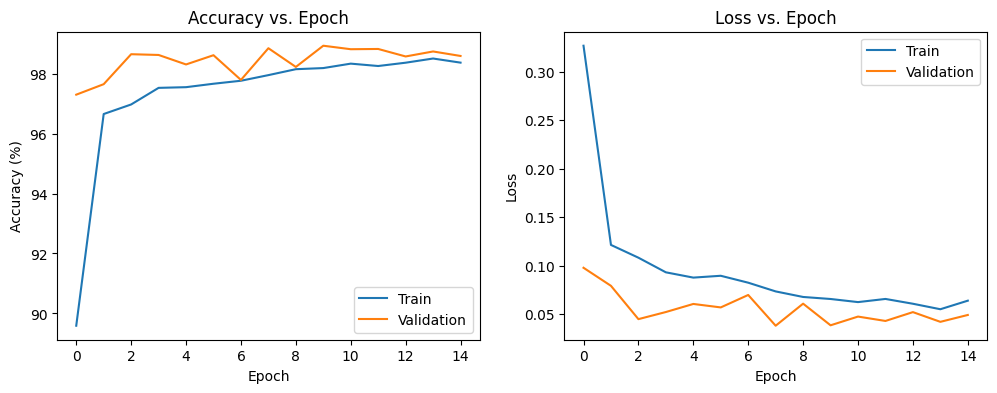

In [40]:
plot_model(train_accs, val_accs, train_losses, val_losses)

SGD optimizer

Epoch [1/15] - Train Loss: 2.3025, Train Accuracy: 10.18% - Validation Loss: 2.3019, Validation Accuracy: 11.18%
Epoch [2/15] - Train Loss: 2.3016, Train Accuracy: 11.30% - Validation Loss: 2.3009, Validation Accuracy: 11.18%
Epoch [3/15] - Train Loss: 2.3008, Train Accuracy: 11.25% - Validation Loss: 2.2999, Validation Accuracy: 11.18%
Epoch [4/15] - Train Loss: 2.2999, Train Accuracy: 11.25% - Validation Loss: 2.2986, Validation Accuracy: 11.18%
Epoch [5/15] - Train Loss: 2.2988, Train Accuracy: 11.25% - Validation Loss: 2.2966, Validation Accuracy: 11.18%
Epoch [6/15] - Train Loss: 2.2968, Train Accuracy: 11.25% - Validation Loss: 2.2930, Validation Accuracy: 11.18%
Epoch [7/15] - Train Loss: 2.2926, Train Accuracy: 13.51% - Validation Loss: 2.2835, Validation Accuracy: 25.14%
Epoch [8/15] - Train Loss: 2.2750, Train Accuracy: 26.50% - Validation Loss: 2.2272, Validation Accuracy: 26.62%
Epoch [9/15] - Train Loss: 1.6668, Train Accuracy: 48.07% - Validation Loss: 0.7155, Validation 

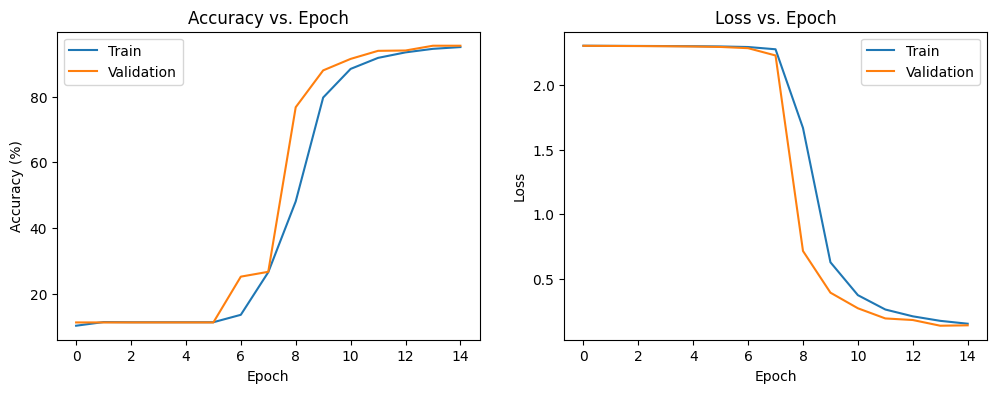

In [21]:
model = AlexNet(num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_accs, train_losses, val_accs, val_losses = train_loop(model, 15, loss_fn, optimizer)
plot_model(train_accs, val_accs, train_losses, val_losses)

Epoch [1/15] - Train Loss: 2.2038, Train Accuracy: 17.39% - Validation Loss: 0.7253, Validation Accuracy: 75.47%
Epoch [2/15] - Train Loss: 0.2225, Train Accuracy: 92.93% - Validation Loss: 0.0857, Validation Accuracy: 97.28%
Epoch [3/15] - Train Loss: 0.0976, Train Accuracy: 96.93% - Validation Loss: 0.0707, Validation Accuracy: 97.70%
Epoch [4/15] - Train Loss: 0.0717, Train Accuracy: 97.73% - Validation Loss: 0.0656, Validation Accuracy: 97.90%
Epoch [5/15] - Train Loss: 0.0584, Train Accuracy: 98.17% - Validation Loss: 0.0537, Validation Accuracy: 98.14%
Epoch [6/15] - Train Loss: 0.0486, Train Accuracy: 98.49% - Validation Loss: 0.0445, Validation Accuracy: 98.64%
Epoch [7/15] - Train Loss: 0.0423, Train Accuracy: 98.67% - Validation Loss: 0.0357, Validation Accuracy: 98.89%
Epoch [8/15] - Train Loss: 0.0383, Train Accuracy: 98.76% - Validation Loss: 0.0343, Validation Accuracy: 98.92%
Epoch [9/15] - Train Loss: 0.0340, Train Accuracy: 98.90% - Validation Loss: 0.0304, Validation 

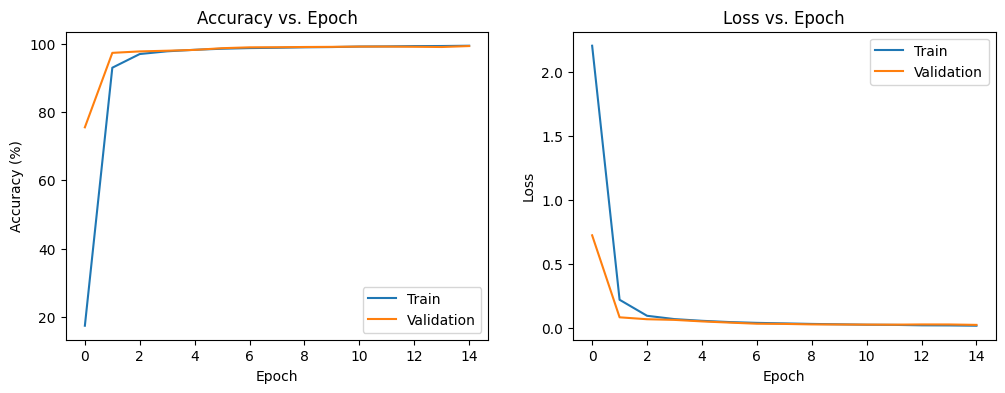

In [22]:
model = AlexNet(num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_accs, train_losses, val_accs, val_losses = train_loop(model, 15, loss_fn, optimizer)
plot_model(train_accs, val_accs, train_losses, val_losses)

Як бачимо з графіків із вище навчених моделей, що при Адам оптимізаторі наша модель уже на першій епосі отримає хороший результат. Так як при використанні стохастичного градієнта, при тому самому значення швидкості навчання, лише на 10 епосі отримуємо майже такий самий хороший результат. Але коли збільшили швидкість навчання для SGD  отримали найкращий результат в 99.27% при досліджувальних параметрах.

Отже, у цій роботі ми реалізували архітектуру AlexNet з нуля за допомогою PyTorch і навчили її на наборі даних MNIST. Ми провели експерименти з різними гіперпараметрами та спостерігали за їхнім впливом на навчання та продуктивність моделі.

*Роботу виконав </br> Бірук Сергій </br>Група КІ-31мп*
